In [1]:
# For reloading modules
import importlib

# My modules config has to be imported first
import config as cfg
import datasets
import utils
import models
import train

import display as disp

import time
import datetime
import tensorflow as tf
import numpy as np

# Video and visualization stuff
import tqdm
import PIL.Image, PIL.ImageDraw

from IPython.display import Image, HTML, clear_output, Video
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from visdom import Visdom

In [36]:
# Reload modules
importlib.reload(utils)
importlib.reload(models)
importlib.reload(datasets)
importlib.reload(cfg)
importlib.reload(train)
importlib.reload(disp)

<module 'display' from '/home/maxi/Documents/UNI/Thesis/dev/SoS/display.py'>

In [37]:
# tensorboard summary writers:
# TODO add to actual logs instead of seperate, maybe
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'tb_logs/' + current_time + '/train'
# test_log_dir = 'tb_logs/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [38]:
# tf.config.run_functions_eagerly(True)

# Load Dataset & Model & Trainer
(x_train, y_train), (x_test, y_test) = datasets.get_data()
ca = models.CAModel(summary_writer=train_summary_writer)

# In order to use visdom, visdom.sh has to be executed
vis = Visdom()
trainer = train.Trainer(x_train, y_train, ca, vis)
utils.save_cfg()
ca.summary()
print(utils.get_cfg_infos())

Setting up a new session...


(40, 40, 4)
Successfully saved configs at:  logs/maybe/2020_12_22/15_12_00/
------------
Model: "dmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 40, 40, 16)]      0         
_________________________________________________________________
perceive (Conv2D)            (None, 40, 40, 128)       18560     
_________________________________________________________________
last_layer (Conv2D)          (None, 40, 40, 16)        2064      
Total params: 20,624
Trainable params: 20,624
Non-trainable params: 0
_________________________________________________________________
dmodel:  None
{}{}{'POOL_TANH': True}{'SESSION_ID': '2020_12_22/15_12_00'}


(40, 320, 4)


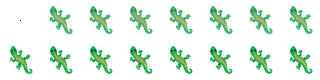

 r: 0 step: 2000, full_loss: 8.962

In [39]:
NUM_RUNS = 1
cfg.TRAIN.NUM_TRAINING_STEPS = 2000

# tf.config.run_functions_eagerly(True)
# tf.random.set_seed(42)
# np.random.seed(42)

w = None
full_log = []
# writer has to be outside as inside the summary for weights are called
with train_summary_writer.as_default():
  for e in range(NUM_RUNS):
    if e > 0:
      ca = models.CAModel()
      trainer = train.Trainer(x_train, y_train, ca, vis)

    for i in range(1, cfg.TRAIN.NUM_TRAINING_STEPS+1):
      x0, x_out, losses, grads, log = trainer.full_train_step(i)
      full_log.append(log)
      trainer.visualize(x0, x_out, losses, grads, e)
  
  # The last, real plot (need to include title_text for real name), textwrap_width for img plot!
  # plot = disp.plot_losses(trainer.loss_log, return_plot=True, title_text=utils.get_cfg_infos(), textwrap_width=80)
  # utils.save_fig(plot, name=f"fig_{e}", as_img=False)


In [35]:
# Save current model
trainer.save_weights(path="models/2020/hidden_layers/2/")

# Save full loss plot
plot = disp.plot_losses(trainer.loss_log, return_plot=True, title_text=utils.get_cfg_infos(),
                        textwrap_width=80)
utils.save_fig(plot, name=f"fig", as_img=True)

In [7]:
# load model
path = "logs/maybe/2020_12_16/13_26_52"
trainer.load_weights(path + "/model")

In [15]:
x_in = trainer.x_train[0:8]
log = {
"cnn":{
    "max":[],
    "min":[],
    "mean":[]},
"in":{
    "max":[],
    "min":[],
    "mean":[]},
"out":{
    "max":[],
    "min":[],
    "mean":[]}
}
x = x_in
for i in range(200):
  x, cnn_l = trainer.ca(x)
  
  log["out"]["max"].append(np.amax(x.numpy()))
  log["out"]["min"].append(np.amin(x.numpy()))
  log["out"]["mean"].append(np.mean(x.numpy()))

  log["cnn"]["max"].append(np.amax(cnn_l.numpy()))
  log["cnn"]["min"].append(np.amin(cnn_l.numpy()))
  log["cnn"]["mean"].append(np.mean(cnn_l.numpy()))


In [16]:
# print(full_log[0])

def mmm(val_dict, title):
  fig = go.Figure()
  plot2 = go.Scatter(y=val_dict["max"], name="maxs")
  plot3 = go.Scatter(y=val_dict["min"], name="mins")
  plot4 = go.Scatter(y=val_dict["mean"], name="means")

  fig.add_traces([plot2, plot3, plot4])
  fig.update_layout(title=title)
  return fig

# mmm(full_log[900]["in"], "in").show()
mmm(log["cnn"], "cnn").show()
mmm(log["out"], "out").show()

In [5]:
# TODO fix tf and np seed
tf.config.run_functions_eagerly(True)
tf.random.set_seed(42)
np.random.seed(42)

def test_full_step(step_counter):
  x0, y0 = trainer.get_new_x_y()

  # trainer.x.assign(x0)
  # trainer.y.assign(y0)

  trainer.num_ca_steps.assign(trainer.get_num_ca_steps())

  
  x = x0
  x_log = [x]
  loss_log = [trainer.batch_l2_loss(x,trainer.y_train[0:8]).numpy()]
  with tf.GradientTape() as g:
      for i in tf.range(trainer.num_ca_steps):
          x = trainer.ca(x)
          x_log.append(x)
          loss_log.append(trainer.batch_l2_loss(x,trainer.y_train[0:8]).numpy())
          
      full_loss = trainer.batch_l2_loss(x,y0)
      # print(full_loss)

  grads = g.gradient(full_loss, trainer.ca.trainable_variables)
  # print(grads)
  normed_grads = []
  for layer_grad in grads:
    # If layer has only one value, don't apply norm
      
    normed_grads.append(layer_grad / (tf.norm(layer_grad) + 1e-8))

  grads = normed_grads
  # grads = [g/(tf.norm(g)+1e-8) for g in grads]

  trainer.optimizer.apply_gradients(zip(grads, trainer.ca.trainable_variables))

  trainer.post_train_step(x, y0, step_counter)
  
  return x_log, full_loss, grads, loss_log

In [6]:
step_counter = 0
for i in range(1):
  cur_x_log, cur_loss, grads, loss_log = test_full_step(step_counter)
  step_counter += 1
  print(f"{step_counter}: cur loss:", cur_loss)

1: cur loss: tf.Tensor(108.101746, shape=(), dtype=float32)


In [13]:
print(trainer.ca.weights[6])

<tf.Variable 'h_prime_h/kernel:0' shape=(1, 1, 16, 1) dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]]], dtype=float32)>


In [7]:
# loss_np = [loss() for loss in loss_log]

fig = go.Figure()
maxs = []
mins = []
means = []
for i in range(len(cur_x_log)):
  maxs.append(np.amax(cur_x_log[i]))
  mins.append(np.amin(cur_x_log[i]))
  means.append(np.mean(cur_x_log[i]))
  
plot = px.scatter(y=loss_log)
plot.show()
# vis.plotlyplot(plot)

plot2 = go.Scatter(y=maxs, name="maxs")
plot3 = go.Scatter(y=mins, name="mins")
plot4 = go.Scatter(y=means, name="means")

fig.add_traces([plot2, plot3, plot4])
fig.show()
# print(cur_x_log[0].shape)
# loss_np
# fig = px.scatter(loss_np)
# fig.show()


In [15]:
print(cur_x_log[1].shape)

(8, 40, 40, 16)


In [5]:
cur_x_log, cur_loss, grads, loss_log = test_full_step(step_counter)
step_counter += 1
print(f"{step_counter}: cur loss:", cur_loss)

NameError: name 'step_counter' is not defined

In [9]:
# x0, y0 = trainer.get_new_x_y()
# print(x0[0][20][20])
print(trainer.individual_l2_loss(cur_x_log[56], trainer.y_train[0:8]))

tf.Tensor(
[2339.7334 2084.4106 2235.3496 2282.2925 2180.666  2155.1914 2179.187
 2294.37  ], shape=(8,), dtype=float32)


In [8]:
from plotly.subplots import make_subplots

def plot_input_layer(step, batch):
  # x expected shape: 40,40,16
  fig = make_subplots(rows=4, cols=4)
  x = cur_x_log[step][batch]
  
  for i in range(1,5):
    for j in range(1,5):
      cur_img = x[:,:,i]
      title = f"max:{np.amax(cur_img):.4f} min:{np.amin(cur_img):.4f} mean:{np.mean(cur_img):.4f}"
      plot = px.imshow(cur_img, labels=dict(x=title))
      
      fig.add_traces(plot.data, rows=i, cols=j)
      # plt.title(f"max:{np.amax(x[:,:,i]):.4f} min:{np.amin(x[:,:,i]):.4f} mean:{np.mean(x[:,:,i]):.4f}")
  # fig.update_layout(coloraxis_showscale=False)
  fig.update_layout(title=f"Step:{step}, Batch:{batch}")
  fig.show()
  

In [12]:
import plotly.io as pio
pio.renderers.default = "browser"
plot_input_layer(50, 0)
# print(cur_x_log[0][0,:,:,0].shape)
# fig = px.imshow(cur_x_log[0][0,:,:,0], labels=dict(x="Stuff"))
# fig.update_layout(coloraxis_showscale=False)
# fig.update_layout(title="stuff")
# fig.show()
# for i in range()
# np.shape(cur_x_log[0])

In [7]:
# Get loss for a single x
# trainer.batch_l2_loss(cur_x_log[56], trainer.y_train[0:8])
# trainer.individual_l2_loss(cur_x_log[56], trainer.y_train[:8])
for i in range(len(grads)):
  print(f"{i}: {np.amax(grads[i])}, {np.amin(grads[i])}, {np.mean(grads[i])}")
  
# print(np.amax(grads[2]))
# print(np.amin())


0: 0.1977989673614502, -0.34699442982673645, -0.19010066986083984
1: -1.0, -1.0, -1.0
2: 0.012802761048078537, -0.007242368534207344, 0.005558519624173641
3: 0.10502995550632477, 0.023829758167266846, 0.08773569017648697
4: 0.06855656206607819, 0.00010105805995408446, 0.018987281247973442
5: 0.3306545317173004, 0.11762639135122299, 0.24128229916095734


In [15]:
# grads[1].shape == tf.TensorShape([1])
print(trainer.ca.weights[1])

<tf.Variable 'update_gate/bias:0' shape=(1,) dtype=float32, numpy=array([0.00806281], dtype=float32)>


In [43]:
# Show plot from above and plot it to visdom
# importlib.reload(disp)

plot = disp.plot_losses(trainer.loss_log, return_plot=True, title_text=utils.get_cfg_infos())
plot.show()
# utils.save_json(plotly.io.to_json(plot))
# utils.save_fig(plot, as_img=True)
vis.plotlyplot(plot) # , env="present")

'window_390c5dc9070226'

In [4]:
# ---------- PLOT AVERAGE SESSION -----------------
# importlib.reload(utils)
# importlib.reload(disp)

# sess_id = "2020_11_14/13_09_57"
sess_id = cfg.EXTRA.SESSION_ID

fig = disp.plot_avg_session(sess_id)
# fig.update_yaxes(type="log")

vis.plotlyplot(fig)
fig.show()


In [3]:
# --- PLOT COLLECTION OF AVERAGE PLOTS ----
# importlib.reload(disp)
plots = utils.grid_plots_simple_nov
disp.plot_collection_of_avg_plots(plots)

In [12]:
import plotly
import plotly.graph_objects as go

# Create single plot with condensed informations


data_idx = [1, 3, 5]
names = ["total", "grow", "persist"]
color_arr = plotly.colors.DEFAULT_PLOTLY_COLORS

test1 = "2020_11_12/15_32_39"
figs = utils.get_all_figs(test1)

# TODO 1k and 2k and 3k?
vals_1000 = np.zeros((4,4))


# TODO plot for axis 1 and 0 and make it nice looking
# Maybe test with different val_to_test
axis = 1 # 0 or 1
val_to_test = 2000
fig = go.Figure()

for i in range(3):
  name = names[i]
  color = color_arr[i]

  for idx, key in enumerate(plots.keys()):
    figs = utils.get_all_figs(key)

    mean_plot, std_plot = disp.avg_plot(figs, data_idx[i], names[i], showlegend=False, color=color_arr[i])
    vals_1000[plots[key][0]-1, plots[key][1]-1] = mean_plot["y"][val_to_test-1]
  
  
  figs_mean = np.mean(vals_1000, axis=axis)
  figs_std = np.std(vals_1000, axis=axis)

  figs_x_single = np.arange(figs_mean.shape[0])
  figs_x = np.concatenate((figs_x_single, figs_x_single[::-1]))
  figs_y_upper = figs_mean + figs_std
  figs_y_lower = figs_mean - figs_std
  figs_y = np.concatenate((figs_y_upper, figs_y_lower[::-1]))

  mean_plot = go.Scatter(y=figs_mean, name=name+"_mean", legendgroup=name+"_mean",
                         showlegend=True, marker_color=color)
  std_plot = go.Scatter(x=figs_x, y=figs_y, name=name+"_std", fill='toself', legendgroup=name+"_std",
                         showlegend=True, marker_color=color, fillcolor=color, opacity=0.5)

  fig.add_trace(mean_plot)
  # fig.add_trace(std_plot)


if axis==0:
  # Layout for Loss to Hidden Filter size
  fig.update_layout(title="",
                    xaxis_title="HIDDEN NETWORK SIZE",
                    yaxis_title=f"LOSS AT {val_to_test}",
                    font=dict(size=18),
                    xaxis= dict(tickmode='array',
                                tickvals=[0, 1, 2, 3],
                                ticktext=['16', '32', '64', '128']))

elif axis==1:
  # Layout for Loss to Hidden states
  fig.update_layout(title="",
                    xaxis_title="# HIDDEN STATES",
                    yaxis_title=f"LOSS AT {val_to_test}",
                    font=dict(size=18),
                    xaxis= dict(tickmode='array',
                                tickvals=[0, 1, 2, 3],
                                ticktext=['8', '16', '32', '64']))

fig.show()
# print(testy)
# print(vals_1000)
# fig = go.Figure()
# for idx in range(vals_1000.shape[1]):
  # print(vals_1000[test,:])
  # fig.add_trace(go.Scatter(y=vals_1000[:, idx]))

# mean_plot, std_plot = disp.avg_plot(fig, data_idx[0], names[0], showlegend=True, color=color_arr[0])
# go.Figure([mean_plot, std_plot]).show()

# fig.show()
# print(vals_1000)
# print(mean_plot["y"][3000-1])
# fig = go.Figure(mean_plot)
# fig.show()
# print(res[0]["data"][0]['y'])

In [23]:
# See all possible renderers for plotly 
import plotly.io as pio
print(pio.renderers)
pio.renderers.default = "notebook_connected"

Renderers configuration
-----------------------
    Default renderer: 'browser'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



In [5]:
# --- Test Performance of ca over time, starting from x_train -------

import textwrap
# tf.config.run_functions_eagerly(True)

cfg.EXTRA.PRINT_LAYER = True

x = trainer.x_train[0:1]
y = trainer.y_train[0]


def test_emoji(x, y):
  loss_arr = []
  for i in range(cfg.WORLD.CA_STEP_RANGE[1] + 150):
    loss = trainer.individual_l2_loss(x,y)
    loss_arr.append(loss)
    x = trainer.ca(x)

  # fig = disp.plot_loss(np.array(loss_arr)[:,0], plot_mean=False, return_plot=True)
  fig = go.Figure(go.Scatter(y=np.array(np.array(loss_arr)[:,0])))
  return fig
  
# TODO all this things not here...
fig = test_emoji(x, y)
title = utils.get_cfg_infos()
fig.layout.title.text = "<br>".join(textwrap.wrap(title, width=120))
fig.layout.title.font.size = 12
fig.show()
# vis.plotlyplot(fig)

TypeError: tuple indices must be integers or slices, not tuple

In [4]:
# ---- VIDEO -----
importlib.reload(disp)
cfg.EXTRA.PRINT_LAYER = False

# Bigger padding around img (cfg.WORLD.SIZE for standard size)
x_big = datasets.add_padding(x_train[0], cfg.WORLD.SIZE + 0)[None, :]

# Y image as start
expanded_y = np.zeros_like(x_train[0:1])
expanded_y[:,:,:,0:4] = y_train[0:1]

# Cut image as start
x_cut = trainer.cut_x(trainer.pool_t[:8])[0:1]

# Create and show video
disp.show_simple_run(x_big, trainer.ca, cfg.WORLD.CA_STEP_RANGE[0] + 150 , only_alive_cells=False,
                     white_background=False)
# vis.video(videofile="./_autoplay.mp4")

(40, 40, 16)


TypeError: tuple indices must be integers or slices, not tuple

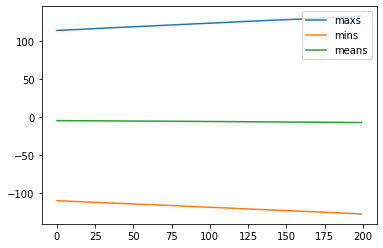

In [14]:
maxs = []
mins = []
means= []

x_all,y = trainer.get_new_emoji_x_y()
x = x_all[0:8]
for i in range(200):
  maxs.append(np.amax(x))
  mins.append(np.amin(x))
  means.append(np.mean(x))
  x = trainer.ca(x)
  
plt.plot(maxs, label="maxs")
plt.plot(mins, label="mins")
plt.plot(means, label="means")
plt.legend()
plt.show()

In [12]:
# print(type(trainer.ca))
# Show model in tensorboard (training is irrelevant, but needed for plots)
y_in = np.zeros_like(trainer.x_train)
y_in[:,:,:,0:4] = trainer.y_train
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="tb_logs/")
ca.compile(optimizer='adam', loss='mse')
ca.fit(trainer.x_train, y_in, batch_size=8, epochs=8, callbacks=tb_callback)

<class 'models.CAModel'>
Epoch 1/8
 1/10 [==>...........................] - ETA: 0s - loss: 0.0190WARNING:tensorflow:From /home/maxi/anaconda3/envs/sos/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10/10 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 2/8
10/10 [==============================] - 0s 4ms/step - loss: 0.0181
Epoch 3/8
10/10 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 4/8
10/10 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 5/8
10/10 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 6/8
10/10 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 7/8
10/10 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 8/8
10/10 [==============================] - 0s 4ms/step - loss

get_new_x_y
mean: 0.0008771225116800343


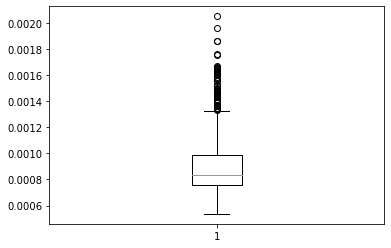

full_train_step
mean: 0.0853380825353778


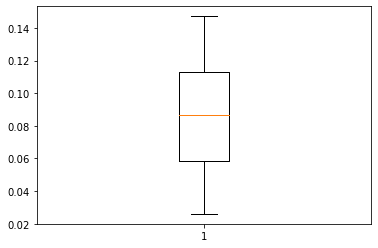

visualize
mean: 0.0022452206776224417


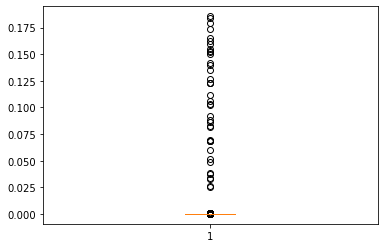

In [18]:
# -- Show execution times as boxplots ---

for key in utils.total_time_dict.keys():
  print(key)
  print("mean:", np.mean(utils.total_time_dict[key][1:]))
  # Removing the first as most time too long and not representative
  plt.boxplot(utils.total_time_dict[key][1:])
  plt.show()

In [ ]:
# --- Test performance (function) on MNIST set ---

# TODO outsource
def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = models.eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]
  return all_accuracies, all_agreements


In [ ]:
# --- Call and exectue the test of performance on the MNIST set ----

eval_batch = 1000
num_iters = 10

# TODO this takes ages!
start_time = time.time()
all_accuracies, all_agreements = eval_all(trainer.ca, num_steps=200, mutate=True)
print("All Acc time: ", time.time() - start_time)

plt.figure(figsize=(10, 4))
plt.title('Average cell accuracy over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average cell accuracy (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_accuracies, label="ca")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Average total agreement across batch over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average total agreement (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_agreements, label="ca")
plt.legend()